In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import argparse
import os
import os.path as osp
import matplotlib.pyplot as plt

In [2]:
a = 'a-meta-self'
print ('meta' in a)

True


In [2]:
def load_result(root):
    modified_adj = torch.load('{}/modified_adj.pt'.format(root)).cpu().detach().numpy()
    adj = torch.load('{}/adj.pt'.format(root)).cpu().detach().numpy()
    labels = torch.load('{}/labels.pt'.format(root)).cpu().detach().numpy()
    ori_e = torch.load('{}/ori_e.pt'.format(root)).cpu().detach().numpy()
    ori_v = torch.load('{}/ori_v.pt'.format(root)).cpu().detach().numpy()
    e = torch.load('{}/e.pt'.format(root)).cpu().detach().numpy()
    v = torch.load('{}/v.pt'.format(root)).cpu().detach().numpy()
    
    return modified_adj, adj, labels, ori_e, ori_v, e, v

In [79]:
folder = 'sanitycheck'
data_seed = 1115
dataset = 'cora'
loss_type = 'CE'
ptb_rate = 0.2
model = 'PGD'
target_node = 'train'

reg_weight1 = 0.0
root1 = './{}/{}dseed_{}_{}_{}rate_{}reg_{}_{}target'.format(folder,
             data_seed, dataset, loss_type, ptb_rate, 
             reg_weight1, model, target_node)
modified_adj1, adj1, labels1, ori_e1, ori_v1, e1, v1 = load_result(root1)

reg_weight2 = -1.0
root2 = './{}/{}dseed_{}_{}_{}rate_{}reg_{}_{}target'.format(folder, 
             data_seed, dataset, loss_type, ptb_rate, 
             reg_weight2, model, target_node)
modified_adj2, adj2, labels2, ori_e2, ori_v2, e2, v2 = load_result(root2)

eigenvalue norm:  24.883453


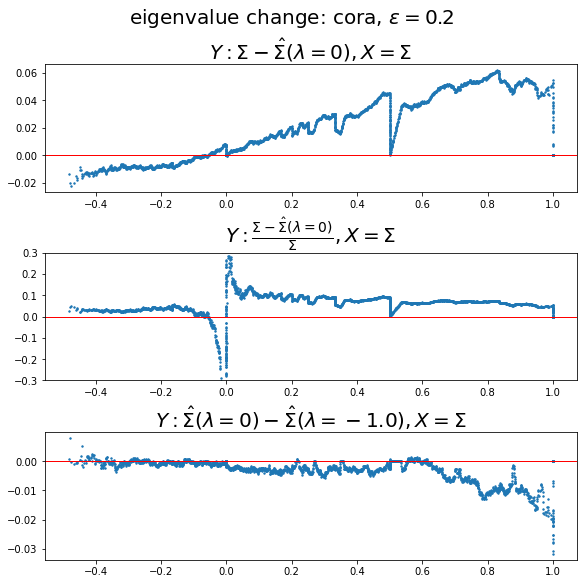

In [80]:
# Eigenvalue analysis
norm = np.linalg.norm(ori_e1)
print ('eigenvalue norm: ', norm)

diff1 = ori_e1 - e1
diff2 = diff1 / ori_e1
diff3 = e1 - e2

x = ori_e1
y1 = diff1
y2 = diff2
y3 = diff3

fig, axs = plt.subplots(3, 1, figsize=(8, 8),constrained_layout=True)
fig.suptitle(r'eigenvalue change: {}, $\epsilon={}$'.format(dataset, ptb_rate), fontsize=20)

axs[0].scatter(x, y1, s=2)
axs[0].axhline(y=0, color='r', linewidth=1)
axs[0].set_title(r'$Y: \Sigma-\hat{\Sigma}({\lambda=0}), X=\Sigma$',fontsize=20)

axs[1].scatter(x, y2, s=2)
axs[1].axhline(y=0, color='r', linewidth=1)
axs[1].set_ylim((-0.3,0.3))
axs[1].set_title(r'$Y: \frac{\Sigma-\hat{\Sigma}(\lambda=0)}{\Sigma}, X=\Sigma$',fontsize=20)

axs[2].scatter(x, y3, s=2)
axs[2].axhline(y=0, color='r', linewidth=1)
axs[2].set_title(r'$Y: \hat{\Sigma}(\lambda=0) - \hat{\Sigma}'+r'(\lambda={a}), X=\Sigma$'.format(a=reg_weight2),fontsize=20)

plt.show()

In [81]:
# edges change
adj = adj2
modified_adj = modified_adj2
labels = labels2

diff_adj = modified_adj - adj

n_node = adj.shape[0]
n_edge = len(np.nonzero(adj)[0])
n_change = len(np.nonzero(diff_adj)[0])

print ('Edge Change')
print ('============================')
print ('node number={}'.format(n_node))
print ('edge number={}'.format(n_edge))
print ('change_number={}'.format(n_change))
print ('ptb_rate={} | change_rate={:.4f}'.format(ptb_rate, n_change/n_edge))

# add edges
add_idxs = np.where(diff_adj == 1)

add_inter = 0
add_intra = 0
for i in range(len(add_idxs[0])):
    n1_idx = add_idxs[0][i]
    n2_idx = add_idxs[1][i]
    n1_label = labels[n1_idx]
    n2_label = labels[n2_idx]
    if n1_label == n2_label:
        add_intra += 1
    else:
        add_inter += 1

# rm edges
rm_idxs = np.where(diff_adj == -1)
rm_inter = 0
rm_intra = 0
for i in range(len(rm_idxs[0])):
    n1_idx = rm_idxs[0][i]
    n2_idx = rm_idxs[1][i]
    n1_label = labels[n1_idx]
    n2_label = labels[n2_idx]
    if n1_label == n2_label:
        rm_intra += 1
    else:
        rm_inter += 1

print ('============================')
print ('     | inter | intra | r_all | inter% | intra% |')
print ('-----------------------------------------------')
print ('add  | {:5d} | {:5d} | {:5d} | {:.4f} | {:.4f} |'.format(add_inter, 
                                                                      add_intra,
                                                                      add_inter + add_intra,
                                                                      add_inter/(add_inter + add_intra),
                                                                      add_intra/(add_inter + add_intra)))
print ('rm   | {:5d} | {:5d} | {:5d} | {:.4f} | {:.4f} |'.format(rm_inter,
                                                                      rm_intra,
                                                                      rm_inter + rm_intra,
                                                                      rm_inter/(rm_inter + rm_intra),
                                                                      rm_intra/(rm_inter + rm_intra)))
print ('c_all| {:5d} | {:5d} | {:5d} | {:.4f} | {:.4f} |'.format(add_inter + rm_inter, 
                                                                      add_intra + rm_intra,
                                                                      add_inter + add_intra + rm_inter + rm_intra,
                                                                      (add_inter + rm_inter)/(add_inter + add_intra + rm_inter + rm_intra),
                                                                      (add_intra + rm_intra)/(add_inter + add_intra + rm_inter + rm_intra)))
print ('add% | {:.3f} | {:.3f} | {:.3f} |'.format(add_inter/(add_inter + rm_inter), 
                                                  add_intra/(add_intra + rm_intra), 
                                                  (add_inter + add_intra)/(add_inter + add_intra + rm_inter + rm_intra)))
print ('rm%  | {:.3f} | {:.3f} | {:.3f} |'.format(rm_inter/(add_inter + rm_inter), 
                                                  rm_intra/(add_intra + rm_intra), 
                                                  (rm_inter + rm_intra)/(add_inter + add_intra + rm_inter + rm_intra)))

Edge Change
node number=2708
edge number=10556
change_number=2082
ptb_rate=0.2 | change_rate=0.1972
     | inter | intra | r_all | inter% | intra% |
-----------------------------------------------
add  |  1778 |    30 |  1808 | 0.9834 | 0.0166 |
rm   |    64 |   210 |   274 | 0.2336 | 0.7664 |
c_all|  1842 |   240 |  2082 | 0.8847 | 0.1153 |
add% | 0.965 | 0.125 | 0.868 |
rm%  | 0.035 | 0.875 | 0.132 |


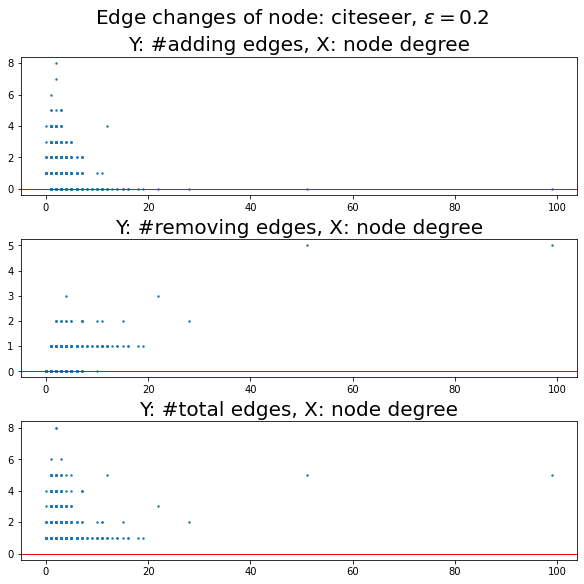

In [54]:
# Node change
add_by_node = np.zeros(diff_adj.shape[0])
for i in range(len(add_idxs[0])):
    n1_idx = add_idxs[0][i]
    n1_label = labels[n1_idx]
    add_by_node[n1_idx] += 1
    
rm_by_node = np.zeros(diff_adj.shape[0])
for i in range(len(rm_idxs[0])):
    n1_idx = rm_idxs[0][i]
    n1_label = labels[n1_idx]
    rm_by_node[n1_idx] += 1

degree_by_node = np.sum(adj, axis=0)

total_by_node = add_by_node + rm_by_node
nonzero_by_node = np.nonzero(total_by_node)

x = degree_by_node[nonzero_by_node]
y1 = add_by_node[nonzero_by_node]
y2 = rm_by_node[nonzero_by_node]
y3 = total_by_node[nonzero_by_node]

fig, axs = plt.subplots(3, 1, figsize=(8, 8),constrained_layout=True)
fig.suptitle(r'Edge changes of node: {}, $\epsilon={}$'.format(dataset, ptb_rate), fontsize=20)

axs[0].scatter(x, y1, s=2)
axs[0].axhline(y=0, color='r', linewidth=1)
axs[0].set_title('Y: #adding edges, X: node degree',fontsize=20)

axs[1].scatter(x, y2, s=2)
axs[1].axhline(y=0, color='r', linewidth=1)
axs[1].set_title('Y: #removing edges, X: node degree',fontsize=20)

axs[2].scatter(x, y3, s=2)
axs[2].axhline(y=0, color='r', linewidth=1)
axs[2].set_title('Y: #total edges, X: node degree',fontsize=20)

plt.show()
